In [ ]:
import yfinance as yf
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

In [ ]:
sp500 = yf.Ticker("QQQ")

In [ ]:
sp500 = sp500.history(period="max")

In [ ]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
1999-03-10 00:00:00-05:00,43.831920,43.858712,43.108532,43.778336,5232000,0.0,0.0,0.0
1999-03-11 00:00:00-05:00,44.099829,44.354354,43.135313,43.992661,9688600,0.0,0.0,0.0
1999-03-12 00:00:00-05:00,43.831938,43.858730,42.572707,42.921005,8743600,0.0,0.0,0.0
1999-03-15 00:00:00-05:00,43.242495,44.207011,42.787029,44.153427,6369000,0.0,0.0,0.0
1999-03-16 00:00:00-05:00,44.340993,44.716083,43.858734,44.528538,4905800,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2023-08-14 00:00:00-04:00,365.429993,370.470001,364.700012,370.350006,42130800,0.0,0.0,0.0
2023-08-15 00:00:00-04:00,369.359985,370.170013,365.739990,366.420013,45539900,0.0,0.0,0.0
2023-08-16 00:00:00-04:00,365.869995,367.429993,362.440002,362.540009,53190500,0.0,0.0,0.0


In [ ]:
sp500.index

DatetimeIndex(['1999-03-10 00:00:00-05:00', '1999-03-11 00:00:00-05:00',
               '1999-03-12 00:00:00-05:00', '1999-03-15 00:00:00-05:00',
               '1999-03-16 00:00:00-05:00', '1999-03-17 00:00:00-05:00',
               '1999-03-18 00:00:00-05:00', '1999-03-19 00:00:00-05:00',
               '1999-03-22 00:00:00-05:00', '1999-03-23 00:00:00-05:00',
               ...
               '2023-08-07 00:00:00-04:00', '2023-08-08 00:00:00-04:00',
               '2023-08-09 00:00:00-04:00', '2023-08-10 00:00:00-04:00',
               '2023-08-11 00:00:00-04:00', '2023-08-14 00:00:00-04:00',
               '2023-08-15 00:00:00-04:00', '2023-08-16 00:00:00-04:00',
               '2023-08-17 00:00:00-04:00', '2023-08-18 00:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=6152, freq=None)

<Axes: xlabel='Date'>

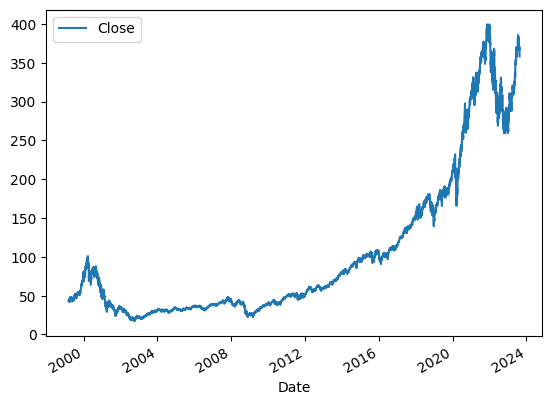

In [ ]:
sp500.plot.line(y="Close", use_index=True)

In [ ]:
del sp500["Dividends"]
del sp500["Stock Splits"]
del sp500["Capital Gains"]

In [ ]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [ ]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [ ]:
sp500 = sp500.loc["1990-01-01":].copy()

<Axes: xlabel='Date'>

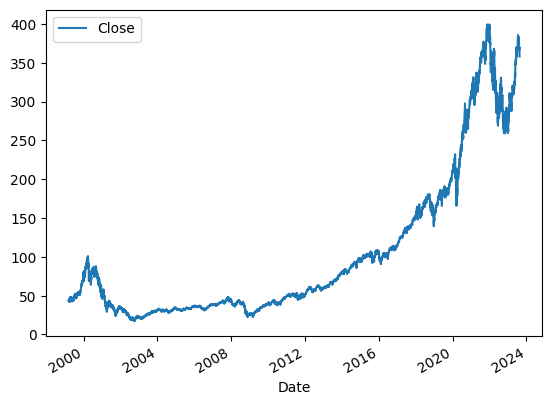

In [ ]:
sp500.plot.line(y="Close", use_index=True)

In [ ]:
def predict(train, test, predictors, model):
  model.fit(train[predictors], train["Target"])
  preds = model.predict_proba(test[predictors])[:,1]
  preds[preds >= .6] = 1
  preds[preds < .6] = 0
  preds = pd.Series(preds, index=test.index, name="Predictions")
  combined = pd.concat([test["Target"], preds], axis=1)
  return combined

In [ ]:
def backtest(data, model, predictors, start=2500, step=250):
  all_predictions = []

  for i in range(start, data.shape[0], step):
    train = data.iloc[:i].copy()
    test = data.iloc[i:(i+step)].copy()
    predictions = predict(train, test, predictors, model)
    all_predictions.append(predictions)
  return pd.concat(all_predictions)

In [ ]:
horizons = [2, 5, 10, 30, 50]
new_predictors = []

for horizon in horizons:
  rolling_average = sp500.rolling(horizon).mean()
  ratio_column = f"Close_Ratio_{horizon}"
  sp500[ratio_column] = sp500["Close"] / rolling_average["Close"]

  trend_column = f"Trend_{horizon}"
  sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

  new_predictors += [ratio_column, trend_column]

sp500 = sp500.dropna()

In [ ]:
model = RandomForestClassifier(n_estimators=500, min_samples_split=25, random_state=1)

In [ ]:
predictions = backtest(sp500, model, new_predictors)
precision_score(predictions["Target"], predictions["Predictions"])
#min samples = 200, .6, 0.5943877551020408
#min samples = 200, .59, 0.5772495755517827
#min samples = 50, .59, 0.5782145782145782
#min samples = 20, .59, 0.5818601076095311
#min samples = 25, .59, 0.5847723704866562 <-- this

0.5842696629213483

In [ ]:
predictions["Predictions"].value_counts()

0.0    2889
1.0     712
Name: Predictions, dtype: int64

In [ ]:
predictions["Target"].value_counts()/predictions.shape[0]

1    0.559034
0    0.440966
Name: Target, dtype: float64

0.5625